# Injecting and Measuring Artificial Stars in Single-Visit Images

Jeff Carlin <br>
Last verified to run Monday, April 26, 2022, with weekly 2022_12.

Recommended container size: large (or possibly medium; small will definitely run out of memory and kill the kernel).


In [62]:
# Import python packages
import time
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import pandas as pd

%matplotlib inline

In [63]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [64]:
# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.pipe.tasks.fakes as fakes

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [65]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [9, 9],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Instantiate the Butler.

In [66]:
# For DC2 gen3, these are the only options
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'

butler = Butler(repo, collections=collection)
registry = butler.registry

#### Create a list of artificial stars to inject: 

To inject artificial stars, all that is needed is a list of RA, Dec positions, and magnitudes to assign the simulated stars.

We will generate `nfakes` stars with positions randomly distributed (using a normal distribution of size `scatter_arcmin` in arcminutes) about the center coordinate (racen, deccen). The stars will be evenly spaced in u-band magnitude (i.e., in `nfakes` equal intervals between magmin and magmax), and randomly distributed about a mean color for each band. (I chose to use a fixed mean color for all stars for simplicity, but apply a normally-distributed scatter of `mag_scatter` magnitudes about this mean value so they are not all identical.)


In [67]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
racen = 59.65688129
deccen = -36.75083078

data =pd.read_csv('input_mags.txt', delim_whitespace=True)
# Place all the fake stars within `scatter_arcmin` arcminutes of the center coordinate:
#scatter_arcmin = 1.0

# Assign positions using a (random) normal distribution about the center coordinates:
fake_ras = data['ra']
fake_decs = data['dec']
fake_gmags = data['mag']

# "nfakes" is the number of fake stars to inject:
nfakes = len(fake_ras)

#THIS IS WRONG. GET THESE FROM MAG NOTEBOOK
fake_umags = fake_gmags+0.5
fake_rmags = fake_gmags-0.2
fake_imags = fake_gmags+0.7


### Look up the images that overlap the desired coordinates

We will use the spatial query method introduced in [notebook 04: Intro to the Butler](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04_Intro_to_Butler.ipynb).

In [68]:
import lsst.sphgeom

pixelization = lsst.sphgeom.HtmPixelization(12)

In [69]:
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(racen, deccen)
    )
)

# Obtain and print the scale to provide a sense of the size of the sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=147183400 at level=12 is a ~6.7e+01" triangle.


#### Now query the registry for all "calexp" images overlapping the desired position:

In [70]:
datasetRefs = registry.queryDatasets("calexp", htm20=htm_id)

print("Found ", datasetRefs.count(discard=True), " calexps at that position.")

Found  520  calexps at that position.


That's nice, but it finds images from all bands overlapping the position in a single iterator. Let's get lists separately for each band:

In [71]:
datasetRefs_u = registry.queryDatasets("calexp", htm20=htm_id, band="u")
datasetRefs_g = registry.queryDatasets("calexp", htm20=htm_id, band="g")
datasetRefs_r = registry.queryDatasets("calexp", htm20=htm_id, band="r")
datasetRefs_i = registry.queryDatasets("calexp", htm20=htm_id, band="i")

print("Found ", datasetRefs_u.count(discard=True), " u-band calexps at that position.")
print("Found ", datasetRefs_g.count(discard=True), " g-band calexps at that position.")
print("Found ", datasetRefs_r.count(discard=True), " r-band calexps at that position.")
print("Found ", datasetRefs_i.count(discard=True), " i-band calexps at that position.")

Found  40  u-band calexps at that position.
Found  60  g-band calexps at that position.
Found  134  r-band calexps at that position.
Found  130  i-band calexps at that position.


For now, let's just grab the first image in the list for each band.

In [72]:
for i, ref in enumerate(datasetRefs_u):
    uref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_g):
    gref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_r):
    rref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_i):
    iref = ref
    if i > 0:
        break


What does that `datasetRef` object look like?

In [73]:
iref

DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 2, visit: 941094, ...}, id=1213b272-1b78-41e5-901d-23aed42468a0, run='2.2i/runs/DP0.1/calexp/v1')

### Make stars and inject them into images:

First, write a function ("makeFakeStar") that takes as inputs the position, flux (intensity), and the PSF, and returns an image of the PSF scaled to the desired flux at the input position.

Next, we add a function ("addFakeStars") that takes the list of RAs, Decs, and magnitudes, and a `datasetRef` for a `calexp` image, and returns a version of the input `calexp` that has the fake stars injected into it. (This function calls "makeFakeStar" for each star in the list.)

The source injection steps were developed following this piece of code as an example: https://github.com/lsst/pipe_tasks/blob/387f8f07a2b66205f9fa6bda9a89dcdbbef3f64c/tests/test_fakeProcessing.py

In [74]:
# make stars at a given position with a given intensity
def makeFakeStar(position, intensity, psf):
    psfImage = psf.computeImage(geom.Point2D(position.x, position.y)).getArray()
    psfImage *= intensity
    noise = np.random.normal(0, np.sqrt(abs(psfImage)))
    return psfImage + noise, noise

In [75]:
def addFakeStars(ras, decs, mags, calexp_ref):
    calexp_inp = butler.get('calexp', calexp_ref.dataId)
    calexp_withFakes = calexp_inp.clone()

    # Fetch objects from the exposure
    psf = calexp_withFakes.getPsf()
    image = calexp_withFakes.getMaskedImage().getImage()
    variance = calexp_withFakes.getMaskedImage().getVariance()
    wcs = calexp_withFakes.getWcs()
    photocalib = calexp_withFakes.getPhotoCalib()

    fluxes = []

    # Use the "photocalib" from the calexp to convert magnitudes to instrumental fluxes:
    for mag in mags:
        fluxes.append(photocalib.magnitudeToInstFlux(mag))

    # Get the corner coordinates of the image:
    y0 = image.getY0()
    x0 = image.getX0()
    ymax = y0 + calexp_withFakes.getDimensions()[1]
    xmax = x0 + calexp_withFakes.getDimensions()[0]

    #xvals = []
    #yvals = []
    
    # At each position create a star with the given intensity and add it
    # to the image.
    for ra, dec, intensity in zip(ras, decs, fluxes):
        # Use the WCS to convert RA, Dec to X, Y pixel coordinates:
        pos = wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees))
        #xvals.append(pos.x)
        #yvals.append(pos.y)

        # Call "makeFakeStar" to get the image of a PSF-like object with the desired flux:
        objArray, noiseArray = makeFakeStar(pos, intensity, psf)
        psfRad = int((objArray.shape[0]-1)/2.)

        # Check that the desired position is within the image:
        oky = (pos.y > psfRad) & (pos.y < ymax - psfRad)
        okx = (pos.x > psfRad) & (pos.x < xmax - psfRad)

        if okx & oky:
            yslice = slice(int(np.floor(pos.y - psfRad - y0)), int(np.floor(pos.y + psfRad + y0 + 1)))
            xslice = slice(int(np.floor(pos.x - psfRad - x0)), int(np.floor(pos.x + psfRad + x0 + 1)))

            print('Injecting source at x, y = ', pos.x, pos.y)

            # NOTE: while image arrays are indexed with x, y, the extraction of the data into (numpy) arrays
            # means that the returned arrays follow numpy's y, x convention.
            # More on indexing: https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html
            image.getArray()[yslice, xslice] += objArray
            variance.getArray()[yslice, xslice] += noiseArray**2
        else:
            print('Skipped injecting source at x, y = ', pos.x, pos.y, ' because it is too close to (or off) the edge.')

    return calexp_inp, calexp_withFakes

### Call the "addFakeStars" function to create calexp images with the artificial stars injected:

In [76]:
calexp_orig_u, calexp_new_u = addFakeStars(fake_ras, fake_decs, fake_umags, uref)
calexp_orig_g, calexp_new_g = addFakeStars(fake_ras, fake_decs, fake_gmags, gref)
calexp_orig_r, calexp_new_r = addFakeStars(fake_ras, fake_decs, fake_rmags, rref)
calexp_orig_i, calexp_new_i = addFakeStars(fake_ras, fake_decs, fake_imags, iref)

Skipped injecting source at x, y =  -13549.791698831526 33553.47131206044  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  -5606.489569348891 914.1916244160492  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  -18449.416275675045 30817.05553163439  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  5554.7914229257085 4275.485145981178  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  -249.50949849390895 -3685.475384482231  because it is too close to (or off) the edge.
Skipped injecting source at x, y =  -824.384625780963 9035.057576231193  because it is too close to (or off) the edge.
Injecting source at x, y =  1046.4987312815776 3799.101183182089
Injecting source at x, y =  2546.599969428865 1258.6211104681192
Skipped injecting source at x, y =  -5090.606784333971 7489.572577063558  because it is too close to (or off) the edge.
Skipped injecting source at

### Wrap all of the detection and measurement steps in a function.

The steps here follow the <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/05_Intro_to_Source_Detection.ipynb">Intro to Source Detection</a> tutorial notebook, so rather than explain them in detail here, we simply wrap all the steps in a single function that can be executed for each image.

In [77]:
def processFakes(calexp_inp):
    
    # Create a basic schema to use with these tasks
    schema = afwTable.SourceTable.makeMinimalSchema()

    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = dafBase.PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 10      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    # Make an empty table that we'll put the results in:
    tab = afwTable.SourceTable.make(schema)
    
    # Image characterization
    result = charImageTask.run(calexp_inp)

    # Get the PSF and some image properties
    psf = calexp_inp.getPsf()
    sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    # Run source detection
    result = sourceDetectionTask.run(tab, calexp_inp)
    
    sources = result.sources
    
    # Run source deblending
    sourceDeblendTask.run(calexp_inp, sources)

    # Run source measurement
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp)

    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    return(source_tab)

### Run the "processFakes" function on each image that we injected fake stars into

**This may take at least a couple minutes to run**

In [32]:
t1 = time.time()

sources_withfakes_u = processFakes(calexp_new_u)
sources_withfakes_g = processFakes(calexp_new_g)
sources_withfakes_r = processFakes(calexp_new_r)
sources_withfakes_i = processFakes(calexp_new_i)

t2 = time.time()
print('dt', t2 - t1)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_11063/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.82 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_11063/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.85 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_11063/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.81 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_11063/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.91 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


dt 72.99305295944214


In [33]:
# Take a look at the catalog:

sources_withfakes_i

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

### Match coordinates from the original list of fake stars to the new catalog:

In [34]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=fake_ras*u.deg, dec=fake_decs*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
sc_withfakes_u = SkyCoord(ra=sources_withfakes_u['coord_ra'], dec=sources_withfakes_u['coord_dec'], frame='icrs')
sc_withfakes_g = SkyCoord(ra=sources_withfakes_g['coord_ra'], dec=sources_withfakes_g['coord_dec'], frame='icrs')
sc_withfakes_r = SkyCoord(ra=sources_withfakes_r['coord_ra'], dec=sources_withfakes_r['coord_dec'], frame='icrs')
sc_withfakes_i = SkyCoord(ra=sources_withfakes_i['coord_ra'], dec=sources_withfakes_i['coord_dec'], frame='icrs')
# Note that units weren't required for sc_withfakes_*, because it already has them.

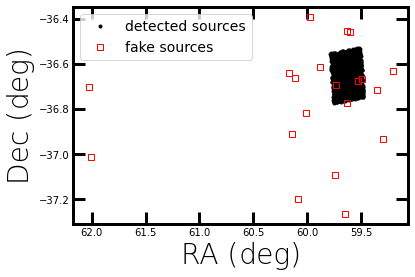

In [35]:
fig, ax = plt.subplots(1, 1)
plt.plot(sc_withfakes_g.ra, sc_withfakes_g.dec, '.k', label='detected sources')
plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
ax.invert_xaxis()
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

In [36]:
# Match them using the Astropy SkyCoord "match_to_catalog_sky" method:

idx_u, sep_u, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_u)
idx_g, sep_g, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_g)
idx_r, sep_r, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_r)
idx_i, sep_i, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_i)

The "idx*" arrays are the indices into sc_withfakes* files to extract the closest match, and "sep*" are the actual separations between the sources. Note that this returns a separation for all objects -- in the following, we will keep only sources with match separations less than 1 arcsecond (i.e., "good" matches).

Extract info about the good matches into arrays:

In [37]:
okmch_u = (sep_u.arcsec < 1.0)
mch_mags_u = sources_withfakes_u[idx_u]['mag_psf']
mch_magerrs_u = sources_withfakes_u[idx_u]['magerr_psf']
# If the nearest match is >1" away, set its magnitudes to -99.9:
mch_mags_u[~okmch_u] = -99.9
mch_magerrs_u[~okmch_u] = 99.9
seps_u = sep_u.arcsec

okmch_g = (sep_g.arcsec < 1.0)
mch_mags_g = sources_withfakes_g[idx_g]['mag_psf']
mch_magerrs_g = sources_withfakes_g[idx_g]['magerr_psf']
mch_mags_g[~okmch_g] = -99.9
mch_magerrs_g[~okmch_g] = 99.9
seps_g = sep_g.arcsec

okmch_r = (sep_r.arcsec < 1.0)
mch_mags_r = sources_withfakes_r[idx_r]['mag_psf']
mch_magerrs_r = sources_withfakes_r[idx_r]['magerr_psf']
mch_mags_r[~okmch_r] = -99.9
mch_magerrs_r[~okmch_r] = 99.9
seps_r = sep_r.arcsec

okmch_i = (sep_i.arcsec < 1.0)
mch_mags_i = sources_withfakes_i[idx_i]['mag_psf']
mch_magerrs_i = sources_withfakes_i[idx_i]['magerr_psf']
mch_mags_i[~okmch_i] = -99.9
mch_magerrs_i[~okmch_i] = 99.9
seps_i = sep_i.arcsec

#print(fake_imags[okmch], sources_withfakes_i[idx_i[okmch]]['mag_psf'])

In [38]:
sep_g.arcsec

array([6.50419384e+03, 1.16262076e+03, 6.55244262e+03, 3.14638454e+02,
       8.46786476e+02, 9.81887513e+02, 3.34060042e-01, 5.05144627e-01,
       1.22730259e+03, 8.01305625e+02, 3.80255289e+02, 7.53051311e+02,
       1.12883526e+03, 1.80726025e+03, 8.32584225e+02, 3.36709970e-01,
       5.88766414e+01, 3.00044683e+02, 2.88746014e+02, 1.80295871e+03])

Combine all of the information into a single table:

In [39]:
tab_all = Table([fake_ras, fake_decs, fake_umags, fake_gmags, fake_rmags, fake_imags,
                 mch_mags_u, mch_magerrs_u, seps_u, mch_mags_g, mch_magerrs_g, seps_g,
                 mch_mags_r, mch_magerrs_r, seps_r, mch_mags_i, mch_magerrs_i, seps_i],
                 names=['ra', 'dec', 'u_fake', 'g_fake', 'r_fake', 'i_fake', 'u_meas', 'uerr_meas', 'sep_u',
                        'g_meas', 'gerr_meas', 'sep_g', 'r_meas', 'rerr_meas', 'sep_r',
                        'i_meas', 'ierr_meas', 'sep_i'],
                 units=[u.deg, u.deg, u.mag, u.mag, u.mag, u.mag, u.mag, u.mag, u.arcsec,
                        u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec])

for col in tab_all.colnames[0:2]:
    tab_all[col].info.format = '%.8g'  # for consistent table output
for col in tab_all.colnames[2:]:
    tab_all[col].info.format = '%.5g'  # for consistent table output


In [40]:
tab_all

ra,dec,u_fake,g_fake,r_fake,i_fake,u_meas,uerr_meas,sep_u,g_meas,gerr_meas,sep_g,r_meas,rerr_meas,sep_r,i_meas,ierr_meas,sep_i
deg,deg,mag,mag,mag,mag,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
62.02918,-36.702508,50.5,50,49.8,50.7,-99.9,99.9,6554.5,-99.9,99.9,6504.2,-99.9,99.9,6741.8,-99.9,99.9,6618.9
59.74366,-37.09373,22.485,21.985,21.785,22.684,-99.9,99.9,1125.1,-99.9,99.9,1162.6,-99.9,99.9,548.08,-99.9,99.9,728.86
62.01019,-37.014077,23.217,22.717,22.517,23.417,-99.9,99.9,6572.1,-99.9,99.9,6552.4,-99.9,99.9,6637.8,-99.9,99.9,6535.1
59.62645,-36.452969,29.552,29.052,28.852,29.752,-99.9,99.9,311.88,-99.9,99.9,314.64,-99.9,99.9,1009.5,-99.9,99.9,811.15
59.29621,-36.931608,22.306,21.806,21.606,22.506,-99.9,99.9,757.2,-99.9,99.9,846.79,-99.9,99.9,366.67,-99.9,99.9,483.11
60.11244,-36.661472,26.906,26.406,26.206,27.106,-99.9,99.9,1044.4,-99.9,99.9,981.89,-99.9,99.9,1263.5,-99.9,99.9,1234.6
59.72886,-36.691183,26.581,26.081,25.881,26.781,-99.9,99.9,14.082,23.145,0.044839,0.33406,-99.9,99.9,203.1,-99.9,99.9,133.39
59.52538,-36.675291,23.446,22.946,22.746,23.646,21.978,0.04184,0.52138,20.388,0.0065308,0.50514,-99.9,99.9,228.08,-99.9,99.9,105.27


Now we have completed all the steps of injecting fake sources, running pipeline tasks to detect and measure all sources in the resulting images, and extracting the matches from the catalogs. Let's look at the results!

Compare the "fake" magnitudes we assigned to each star to their output (measured) magnitude:

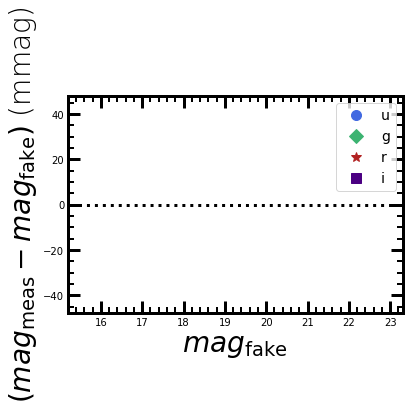

In [41]:
fig = plt.plot(figsize=(9, 9))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(tab_all['u_fake'], 1000.0 * (tab_all['u_meas'] - tab_all['u_fake']),
         'o', ms=10, color='royalblue', label='u')
plt.plot(tab_all['g_fake'], 1000.0 * (tab_all['g_meas'] - tab_all['g_fake']),
         'D', ms=10, color='mediumseagreen', label='g')
plt.plot(tab_all['r_fake'], 1000.0 * (tab_all['r_meas'] - tab_all['r_fake']),
         '*', ms=10, color='firebrick', label='r')
plt.plot(tab_all['i_fake'], 1000.0 * (tab_all['i_meas'] - tab_all['i_fake']),
         's', ms=10, color='indigo', label='i')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
plt.xlim(15.2, 23.3)
plt.ylim(-48, 48)
plt.minorticks_on()
plt.show()

Looks good! (Note that the y-axis is showing residuals in _millimags_.)

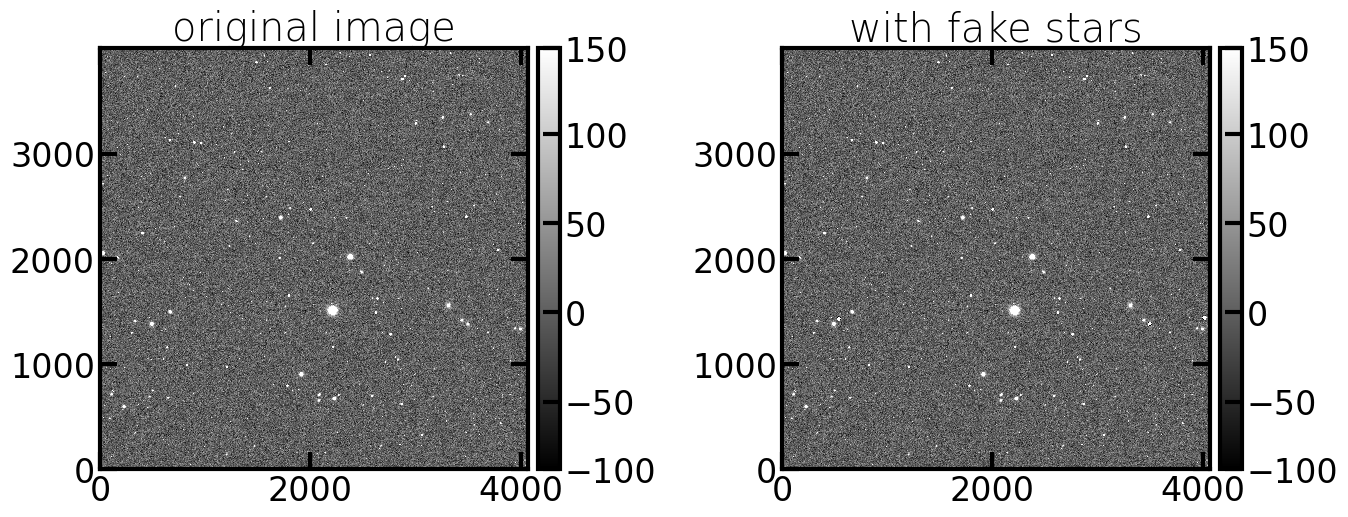

In [78]:
from astropy.io import fits

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp_orig_g.image)

#outfile = 'calexp_orig.fits'
#hdu = fits.PrimaryHDU(calexp_orig_g.image)
#hdu.writeto(outfile, overwrite=True)

plt.title('original image')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(calexp_new_g.image)
# display2.mtv(image0)
plt.title('with fake stars')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.tight_layout()
plt.show()

Ideas for further exploration:

- Inject stars using a realistic stellar population (i.e., get colors and a luminosity function from isochrones).
- Inject galaxies or other objects.
- Inject periodic variables into a set of overlapping visit images (using their time of observation to determine the input phase, and thus magnitude, for each image).
- Test completeness of detection/measurement (will need to inject stars over a variety of magnitudes and colors, and probably many times over to build up a large enough statistical sample).
